In [1]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install wget
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 7.5 MB/s 
     |████████████████████████████████| 6.5 MB 49.5 MB/s 
     |████████████████████████████████| 895 kB 58.8 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=8f0c54c0c33a29a9f11c7bc7a97bfba9b9557b0211cf9976debf05c6fe9f8632
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.2 MB 7.1 MB/s 


In [2]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd, numpy as np
import random, torch, wget, os
from tqdm import tqdm

In [3]:
pd.set_option('precision', 2)

local = False
gpu = True
epochs = 4
batch_size = 32

# If there's a GPU available...
if torch.cuda.is_available() and not local:
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    gpu = False

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Dowloading dataset

In [4]:
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv", 'webis_train.csv')
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv", 'webis_test.csv')

'webis_test.csv'

### Reading dataset and splitting training data

In [5]:
def cast_labels(data: pd.core.series.Series):
    data[data=="no-clickbait"] = 0
    data[data=="clickbait"] = 1
    return data

df = pd.read_csv("webis_train.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df = df[["postText", "truthClass"]].dropna()
training_sentences = df.postText
training_labels = cast_labels(df.truthClass)

training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(training_sentences, 
                                                                                                training_labels, test_size=0.1, random_state=42, stratify=training_labels)

df = pd.read_csv("webis_test.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df = df[["postText", "truthClass"]].dropna()
test_sentences = df.postText
test_labels = cast_labels(df.truthClass)

del df
print('Number of training sentences: {:,}\n'.format(training_sentences.shape[0]))
print('Number of validation sentences: {:,}\n'.format(validation_sentences.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_sentences.shape[0]))
max_length = max([max(map(len, training_sentences)), max(map(len, validation_sentences)), max(map(len, test_sentences))])
print('Max length: {:,}\n'.format(max_length))
# manual setting max_length to 200 to ensure compatibility after tokenization.
max_length = 200

Number of training sentences: 17,535

Number of validation sentences: 1,949

Number of test sentences: 18,913

Max length: 124



In [6]:
if local:
    tokenizer = BertTokenizer.from_pretrained('./bert_models/bert-base-uncased/')
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
def cast_data(data: pd.core.series.Series, max_length):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      
                            truncation=True,
                            max_length = max_length,
                            padding = "max_length",
                            return_attention_mask = True,
                            return_tensors = 'pt'
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [8]:
training_ids, training_attention = cast_data(training_sentences, max_length)
training_labels = torch.tensor(training_labels.to_list())
validation_ids, validation_attention = cast_data(validation_sentences, max_length)
validation_labels = torch.tensor(validation_labels.to_list())

In [9]:
training_dataset = TensorDataset(training_ids, training_attention, training_labels)
train_dataloader = DataLoader(training_dataset,  sampler = RandomSampler(training_dataset),  batch_size = batch_size)
validation_dataset = TensorDataset(validation_ids, validation_attention, validation_labels)
validation_dataloader = DataLoader(validation_dataset, sampler = SequentialSampler(validation_dataset), batch_size = batch_size)

In [10]:
if local:
    model = BertForSequenceClassification.from_pretrained("./bert_models/bert-base-cased/", 
                                                          num_labels = 2, 
                                                          output_attentions = False, output_hidden_states = False)
else:
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                          num_labels = 2, 
                                                          output_attentions = False, output_hidden_states = False)
if gpu:
    model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
optimizer = AdamW(model.parameters(), lr = 2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    labels_flat = labels.flatten()
    return np.sum(np.argmax(preds, axis=1).flatten() == labels_flat) / len(labels_flat)

### Model training

In [13]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

history = []

for epoch_i in range(0, epochs):
    total_train_loss = 0
    
    model.train()

    progress_bar = tqdm(enumerate(train_dataloader), desc="Training epoch "+str(epoch_i), miniters=20)
    for step, batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).to_tuple()

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    

    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    
    
    print("")
    print("Running Validation...")


    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    progress_bar = tqdm(validation_dataloader, desc="Processing validation dataset", miniters=20)

    # Evaluate data for one epoch
    for batch in progress_bar:        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            loss, logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).to_tuple()
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    
    history.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )

Training epoch 0: 548it [05:30,  1.66it/s]



  Average training loss: 0.37

Running Validation...


Processing validation dataset: 100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


  Accuracy: 0.85
  Validation Loss: 0.33


Training epoch 1: 548it [05:30,  1.66it/s]



  Average training loss: 0.29

Running Validation...


Processing validation dataset: 100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


  Accuracy: 0.85
  Validation Loss: 0.34


Training epoch 2: 548it [05:30,  1.66it/s]



  Average training loss: 0.19

Running Validation...


Processing validation dataset: 100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


  Accuracy: 0.84
  Validation Loss: 0.43


Training epoch 3: 548it [05:30,  1.66it/s]



  Average training loss: 0.12

Running Validation...


Processing validation dataset: 100%|██████████| 61/61 [00:12<00:00,  4.96it/s]

  Accuracy: 0.84
  Validation Loss: 0.58


### Training stats

In [14]:
df_stats = pd.DataFrame(data=history).set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.37,0.33,0.85
2,0.29,0.34,0.85
3,0.19,0.43,0.84
4,0.12,0.58,0.84


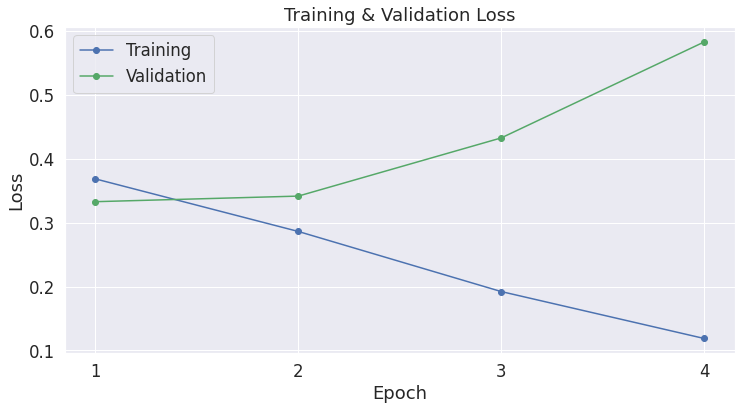

In [15]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

## Testing the model

In [16]:
test_ids, test_attention = cast_data(test_sentences, max_length)
test_labels = torch.tensor(test_labels.to_list())
prediction_data = TensorDataset(test_ids, test_attention, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=32)

In [17]:
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask).to_tuple()
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions+=[np.argmax(x) for x in logits.tolist()]
    true_labels+=label_ids.tolist()

In [18]:
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predictions, average="macro")
print("Precision", precision)
print("Recall", recall)
print("Fscore", fscore)

Precision 0.7985546980053372
Recall 0.7870747833773197
Fscore 0.7925186303770153
